--BOTS BEHAVIOUR-- --SOURCE OF ALPHA-- --COME ONNNN--

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# --- Configuration ---
HISTORICAL_DATA_DIR = 'C:/Users/Admin/Downloads/round-2-island-data-bottle/round-2-island-data-bottle' 
DAYS_TO_LOAD = [-1, -0, 1]
PRODUCTS_TO_ANALYZE = ["KELP", "SQUID_INK"]

# --- Data Loading Function ---
def load_historical_data_day(directory_path, day):
    """Loads prices and trades CSV for a specific day."""
    day_str = str(day)
    prices_path = os.path.join(directory_path, f'prices_round_2_day_{day_str}.csv')
    trades_path = os.path.join(directory_path, f'trades_round_2_day_{day_str}.csv')

    df_prices = None
    df_trades = None

    try:
        if os.path.exists(prices_path):
            df_prices = pd.read_csv(prices_path, sep=';')
            df_prices['day'] = day
            print(f"  Loaded prices for day {day} (Shape: {df_prices.shape})")
        else:
            print(f"  Warning: Prices file not found for day {day}: {prices_path}")
    except Exception as e:
        print(f"  Error loading prices for day {day}: {e}")

    try:
        if os.path.exists(trades_path):
            df_trades = pd.read_csv(trades_path, sep=';')
            df_trades['day'] = day
            print(f"  Loaded trades for day {day} (Shape: {df_trades.shape})")
        else:
            print(f"  Warning: Trades file not found for day {day}: {trades_path}")
    except Exception as e:
        print(f"  Error loading trades for day {day}: {e}")

    return df_prices, df_trades

# --- Load Data for All Days ---
all_prices = []
all_trades = []

print(f"Loading historical data from: {os.path.abspath(HISTORICAL_DATA_DIR)}")
for day in DAYS_TO_LOAD:
    prices_df, trades_df = load_historical_data_day(HISTORICAL_DATA_DIR, day)
    if prices_df is not None:
        all_prices.append(prices_df)
    if trades_df is not None:
        all_trades.append(trades_df)

# --- Combine and Prepare DataFrames ---
if all_prices:
    prices_full_df = pd.concat(all_prices, ignore_index=True)
    # Filter for relevant products early
    prices_full_df = prices_full_df[prices_full_df['product'].isin(PRODUCTS_TO_ANALYZE)].copy()
    prices_full_df.sort_values(by=['day', 'timestamp'], inplace=True)
    prices_full_df.reset_index(drop=True, inplace=True)
    print(f"\nCombined Prices DataFrame shape: {prices_full_df.shape}")
    print(f"Products in Prices: {prices_full_df['product'].unique()}")
else:
    prices_full_df = pd.DataFrame()
    print("\nNo price data loaded.")

if all_trades:
    trades_full_df = pd.concat(all_trades, ignore_index=True)
    # Filter for relevant products early
    trades_full_df = trades_full_df[trades_full_df['symbol'].isin(PRODUCTS_TO_ANALYZE)].copy()
    trades_full_df.sort_values(by=['day', 'timestamp'], inplace=True)
    trades_full_df.reset_index(drop=True, inplace=True)
    print(f"\nCombined Trades DataFrame shape: {trades_full_df.shape}")
    print(f"Symbols in Trades: {trades_full_df['symbol'].unique()}")
else:
    trades_full_df = pd.DataFrame()
    print("\nNo trade data loaded.")

# Display head of the combined dataframes
print("\nPrices Head:")
print(prices_full_df.head())

print("\nTrades Head:")
print(trades_full_df.head())

Loading historical data from: C:\Users\Admin\Downloads\round-2-island-data-bottle\round-2-island-data-bottle
  Loaded prices for day -1 (Shape: (80000, 17))
  Loaded trades for day -1 (Shape: (12144, 8))
  Loaded prices for day 0 (Shape: (80000, 17))
  Loaded trades for day 0 (Shape: (12095, 8))
  Loaded prices for day 1 (Shape: (80000, 17))
  Loaded trades for day 1 (Shape: (12015, 8))

Combined Prices DataFrame shape: (60000, 17)
Products in Prices: ['SQUID_INK' 'KELP']

Combined Trades DataFrame shape: (17672, 8)
Symbols in Trades: ['KELP' 'SQUID_INK']

Prices Head:
   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0   -1          0  SQUID_INK         2005             1       2002.0   
1   -1          0       KELP         2028             1       2026.0   
2   -1        100       KELP         2025            24          NaN   
3   -1        100  SQUID_INK         2004            24          NaN   
4   -1        200       KELP         2025            22         

ANALYSES 1


Calculating total bid/ask volumes...
Total volumes calculated.
   day  timestamp    product  total_bid_volume  total_ask_volume
0   -1          0  SQUID_INK              32.0              31.0
1   -1          0       KELP              32.0              31.0
2   -1        100       KELP              24.0              24.0
3   -1        100  SQUID_INK              24.0              24.0
4   -1        200       KELP              22.0              20.0

Pivoting DataFrame...
DataFrame pivoted.
   day  timestamp  total_ask_volume_KELP  total_ask_volume_SQUID_INK  \
0   -1          0                   31.0                        31.0   
1   -1        100                   24.0                        24.0   
2   -1        200                   20.0                        20.0   
3   -1        300                   31.0                        31.0   
4   -1        400                   27.0                        27.0   

   total_bid_volume_KELP  total_bid_volume_SQUID_INK  
0               

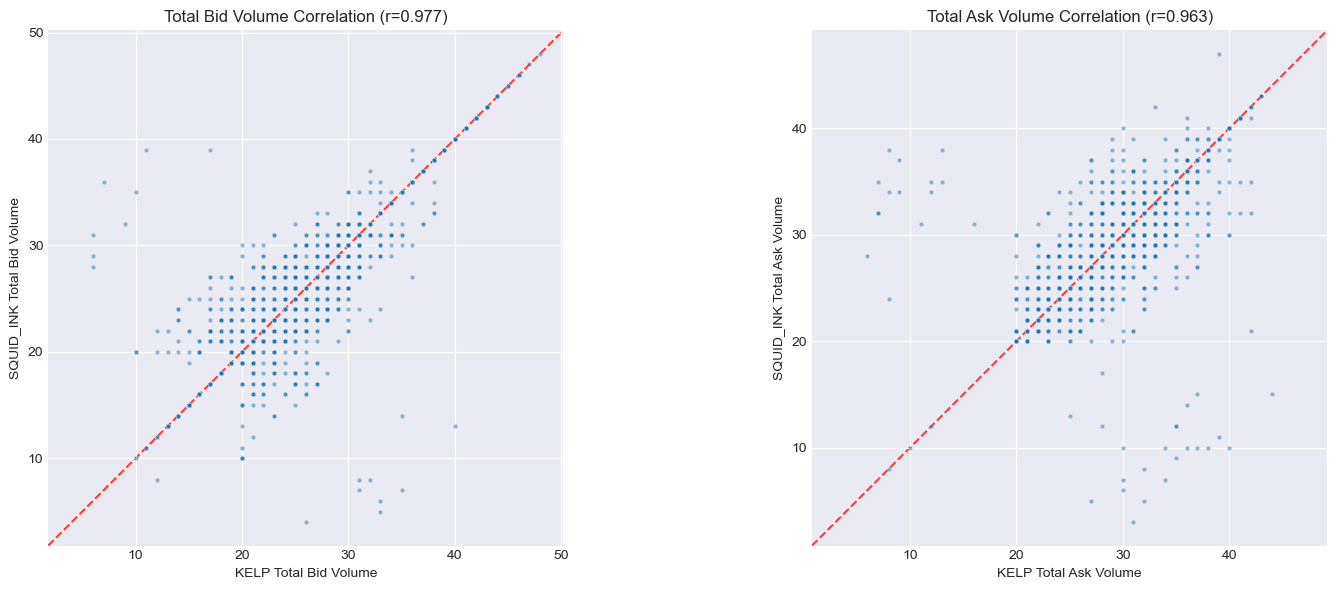

In [4]:
# --- Analysis 1: Cross-Product LOB Volume Correlation ---

# 1. Calculate Total Bid/Ask Volumes for each product
print("\nCalculating total bid/ask volumes...")
volume_cols = {
    'bid': ['bid_volume_1', 'bid_volume_2', 'bid_volume_3'],
    'ask': ['ask_volume_1', 'ask_volume_2', 'ask_volume_3']
}

for side, cols in volume_cols.items():
    # Fill missing volume levels with 0 before summing
    for col in cols:
        if col not in prices_full_df.columns:
            prices_full_df[col] = 0 # Add column if completely missing
        else:
            prices_full_df[col] = prices_full_df[col].fillna(0)
    prices_full_df[f'total_{side}_volume'] = prices_full_df[cols].sum(axis=1)

print("Total volumes calculated.")
print(prices_full_df[['day', 'timestamp', 'product', 'total_bid_volume', 'total_ask_volume']].head())

# 2. Pivot the DataFrame for easier comparison
print("\nPivoting DataFrame...")
# Select only the columns needed for this analysis before pivoting
volume_df = prices_full_df[['day', 'timestamp', 'product', 'total_bid_volume', 'total_ask_volume']].copy()

pivoted_volumes = volume_df.pivot_table(
    index=['day', 'timestamp'],
    columns='product',
    values=['total_bid_volume', 'total_ask_volume']
)

# Flatten the multi-index columns (e.g., ('total_bid_volume', 'KELP') -> 'total_bid_volume_KELP')
pivoted_volumes.columns = [f'{val}_{prod}' for val, prod in pivoted_volumes.columns]
pivoted_volumes.reset_index(inplace=True)

print("DataFrame pivoted.")
print(pivoted_volumes.head())

# 3. Handle Missing Timestamps/Data
# For correlation, we need pairs of values. Drop rows where either product is missing.
pivoted_volumes_clean = pivoted_volumes.dropna(subset=[
    'total_bid_volume_KELP', 'total_bid_volume_SQUID_INK',
    'total_ask_volume_KELP', 'total_ask_volume_SQUID_INK'
])
print(f"\nOriginal pivoted shape: {pivoted_volumes.shape}, Shape after dropping NaNs: {pivoted_volumes_clean.shape}")

# 4. Calculate and Print Correlations
if not pivoted_volumes_clean.empty:
    bid_corr, bid_p_value = pearsonr(pivoted_volumes_clean['total_bid_volume_KELP'], pivoted_volumes_clean['total_bid_volume_SQUID_INK'])
    ask_corr, ask_p_value = pearsonr(pivoted_volumes_clean['total_ask_volume_KELP'], pivoted_volumes_clean['total_ask_volume_SQUID_INK'])

    print("\n--- Volume Correlations ---")
    print(f"Correlation between KELP and SQUID_INK Total Bid Volume: {bid_corr:.4f} (p-value: {bid_p_value:.4g})")
    print(f"Correlation between KELP and SQUID_INK Total Ask Volume: {ask_corr:.4f} (p-value: {ask_p_value:.4g})")

    # 5. Visualize Correlations
    print("\nGenerating scatter plots...")
    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Bid Volume Scatter Plot
    sns.scatterplot(data=pivoted_volumes_clean, x='total_bid_volume_KELP', y='total_bid_volume_SQUID_INK', ax=axes[0], alpha=0.5, s=10) # smaller points
    axes[0].set_title(f'Total Bid Volume Correlation (r={bid_corr:.3f})')
    axes[0].set_xlabel('KELP Total Bid Volume')
    axes[0].set_ylabel('SQUID_INK Total Bid Volume')
    # Add a reference line (y=x)
    lims = [
        min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
        max(axes[0].get_xlim()[1], axes[0].get_ylim()[1]),
    ]
    axes[0].plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    axes[0].set_xlim(lims)
    axes[0].set_ylim(lims)
    axes[0].set_aspect('equal', adjustable='box') # Make axes equal

    # Ask Volume Scatter Plot
    sns.scatterplot(data=pivoted_volumes_clean, x='total_ask_volume_KELP', y='total_ask_volume_SQUID_INK', ax=axes[1], alpha=0.5, s=10)
    axes[1].set_title(f'Total Ask Volume Correlation (r={ask_corr:.3f})')
    axes[1].set_xlabel('KELP Total Ask Volume')
    axes[1].set_ylabel('SQUID_INK Total Ask Volume')
    # Add a reference line (y=x)
    lims = [
        min(axes[1].get_xlim()[0], axes[1].get_ylim()[0]),
        max(axes[1].get_xlim()[1], axes[1].get_ylim()[1]),
    ]
    axes[1].plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    axes[1].set_xlim(lims)
    axes[1].set_ylim(lims)
    axes[1].set_aspect('equal', adjustable='box') # Make axes equal

    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough overlapping data to calculate correlations or plot.")


TRADE CORRELATION


Aggregating trade data...
Trade data aggregated.

Pivoting aggregated trade data...
Aggregated trade data pivoted.

Merging LOB volumes and trade data...
Merge complete.

Calculating lagged trade features...
Lagged features calculated. Shape after dropping NaNs from lag: (29997, 14)

Calculating correlation matrix...
Correlation matrix calculated.

Generating correlation heatmap...


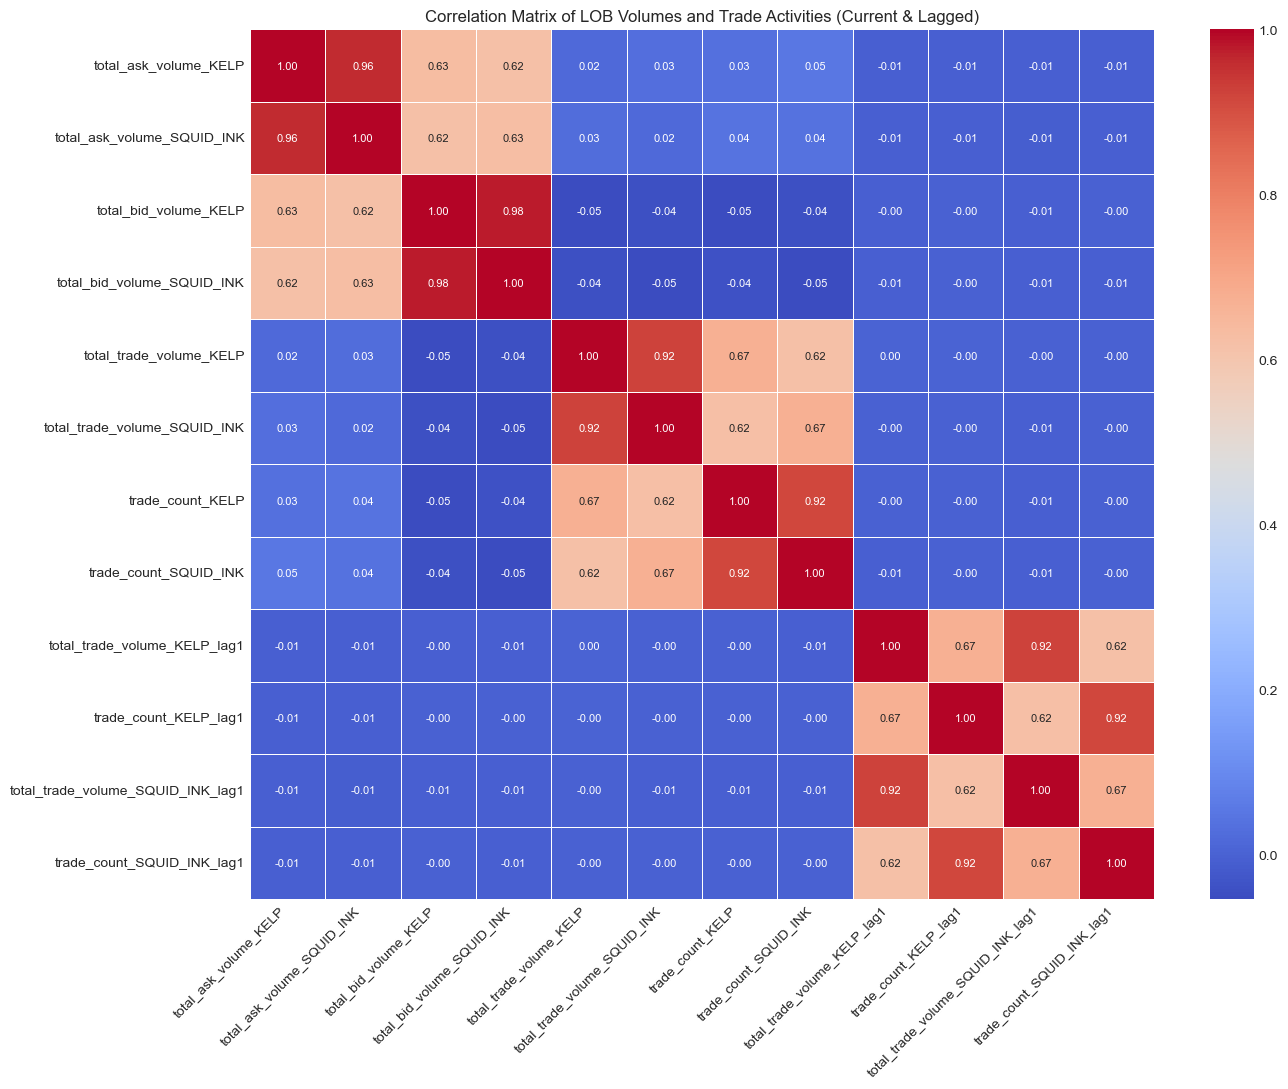

In [5]:
# --- Analysis 2: Trade Volume/Count Correlation with LOB Volumes ---
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

PRODUCTS_TO_ANALYZE = ['KELP', 'SQUID_INK'] # Add other products if needed


try:
    trades_full_df
    pivoted_volumes_clean
except NameError:
    print("Error: Ensure 'trades_full_df' and 'pivoted_volumes_clean' are defined from previous cells.")
    

# 1. Aggregate Trade Volume and Count per Timestamp
print("\nAggregating trade data...")
if not trades_full_df.empty:
    # Group by day, timestamp, and symbol, then sum quantity and count trades
    trades_agg = trades_full_df.groupby(['day', 'timestamp', 'symbol']).agg(
        total_trade_volume=('quantity', 'sum'),
        trade_count=('quantity', 'count')
    ).reset_index()
    print("Trade data aggregated.")
    # print(trades_agg.head())

    # 2. Pivot the aggregated trade data
    print("\nPivoting aggregated trade data...")
    pivoted_trades = trades_agg.pivot_table(
        index=['day', 'timestamp'],
        columns='symbol',
        values=['total_trade_volume', 'trade_count'],
        fill_value=0 # Fill timestamps with no trades for a product with 0
    )
    pivoted_trades.columns = [f'{val}_{prod}' for val, prod in pivoted_trades.columns]
    pivoted_trades.reset_index(inplace=True)
    print("Aggregated trade data pivoted.")
    # print(pivoted_trades.head())

    # 3. Merge with Clean Pivoted LOB Volumes
    print("\nMerging LOB volumes and trade data...")
    # Use the cleaned LOB data (pivoted_volumes_clean from Analysis 1)
    merged_df = pd.merge(pivoted_volumes_clean, pivoted_trades, on=['day', 'timestamp'], how='left')
    # Fill NaNs that might result from the merge (timestamps present in LOB but not trades)
    trade_cols_to_fill = [col for col in merged_df.columns if 'trade_volume' in col or 'trade_count' in col]
    merged_df[trade_cols_to_fill] = merged_df[trade_cols_to_fill].fillna(0)
    print("Merge complete.")
    # print(merged_df.head())

    # 4. Calculate Lagged Trade Features
    print("\nCalculating lagged trade features...")
    merged_df.sort_values(by=['day', 'timestamp'], inplace=True)
    lagged_cols = []
    for product in PRODUCTS_TO_ANALYZE:
        trade_vol_col = f'total_trade_volume_{product}'
        trade_count_col = f'trade_count_{product}'
        lagged_vol_col = f'total_trade_volume_{product}_lag1'
        lagged_count_col = f'trade_count_{product}_lag1'
        if trade_vol_col in merged_df.columns:
            # Ensure grouping by day to prevent lag bleeding across days
            merged_df[lagged_vol_col] = merged_df.groupby('day')[trade_vol_col].shift(1)
            lagged_cols.append(lagged_vol_col)
        if trade_count_col in merged_df.columns:
             # Ensure grouping by day
            merged_df[lagged_count_col] = merged_df.groupby('day')[trade_count_col].shift(1)
            lagged_cols.append(lagged_count_col)

    # Drop rows with NaN in lagged features (first timestamp of each day)
    merged_df_clean_lagged = merged_df.dropna(subset=lagged_cols)
    print(f"Lagged features calculated. Shape after dropping NaNs from lag: {merged_df_clean_lagged.shape}")

    # 5. Compute Correlation Matrix
    print("\nCalculating correlation matrix...")
    lob_cols = [col for col in pivoted_volumes_clean.columns if col not in ['day', 'timestamp']]
    trade_cols_current = [col for col in pivoted_trades.columns if col not in ['day', 'timestamp']]
    trade_cols_lagged = lagged_cols
    correlation_cols = lob_cols + trade_cols_current + trade_cols_lagged

    # Ensure all columns actually exist in the final dataframe
    correlation_cols = [col for col in correlation_cols if col in merged_df_clean_lagged.columns]

    if len(correlation_cols) > 1 and not merged_df_clean_lagged.empty:
        correlation_matrix = merged_df_clean_lagged[correlation_cols].corr()
        print("Correlation matrix calculated.")

        # 6. Visualize the Correlation Matrix (Heatmap)
        print("\nGenerating correlation heatmap...")
        plt.figure(figsize=(14, 11)) # Adjusted size for potentially more columns
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8}) # Smaller font size
        plt.title('Correlation Matrix of LOB Volumes and Trade Activities (Current & Lagged)')
        plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    elif merged_df_clean_lagged.empty:
         print("\nNot enough data after processing (merged_df_clean_lagged is empty) to calculate correlation matrix.")
    else:
        print("\nNot enough columns available or data points in 'merged_df_clean_lagged' to calculate correlation matrix.")

else:
    print("\nNo trade data available ('trades_full_df' is empty) to perform Analysis 2.")


ANALYSES 3


--- Analysis 2 (Continued): Trade Characterization ---

Calculating trade size statistics...

Trade Size Statistics per Product:
               mean  median       std  min  max  count
symbol                                                
KELP       2.845823     1.0  3.341027    0   15   8834
SQUID_INK  2.852229     1.0  3.339000    0   15   8838

Plotting trade size histograms...


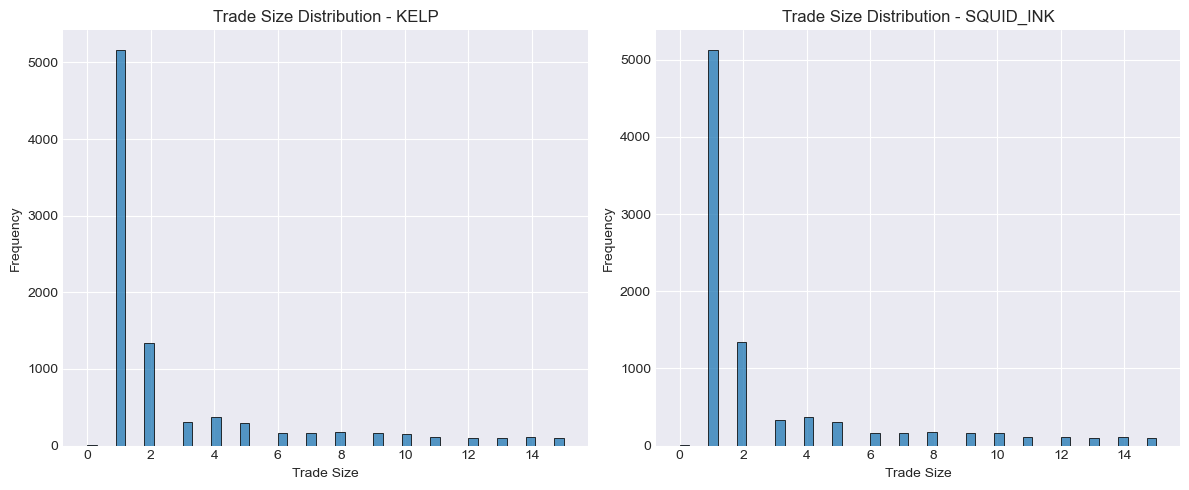


--- Analysis 3: Trade Volume vs LOB Volume Discrepancy ---

Calculating LOB depth and Trade-to-LOB ratios...

Statistics for trade_to_lob_ratio_KELP:
count    29997.000000
mean         0.016056
std          0.047055
min          0.000000
25%          0.000000
50%          0.000000
75%          0.015385
90%          0.035714
95%          0.100000
99%          0.257143
max          0.700000
Name: trade_to_lob_ratio_KELP, dtype: float64

Top 5 timestamps with highest 'trade_to_lob_ratio_KELP' (above 0.1000):
       day  timestamp  total_lob_depth_KELP  total_trade_volume_KELP  \
25147    1     514700                  40.0                     28.0   
10947    0      94700                  40.0                     24.0   
7187    -1     718700                  46.0                     27.0   
11019    0     101900                  42.0                     22.0   
851     -1      85100                  52.0                     27.0   

       trade_to_lob_ratio_KELP  
25147                 

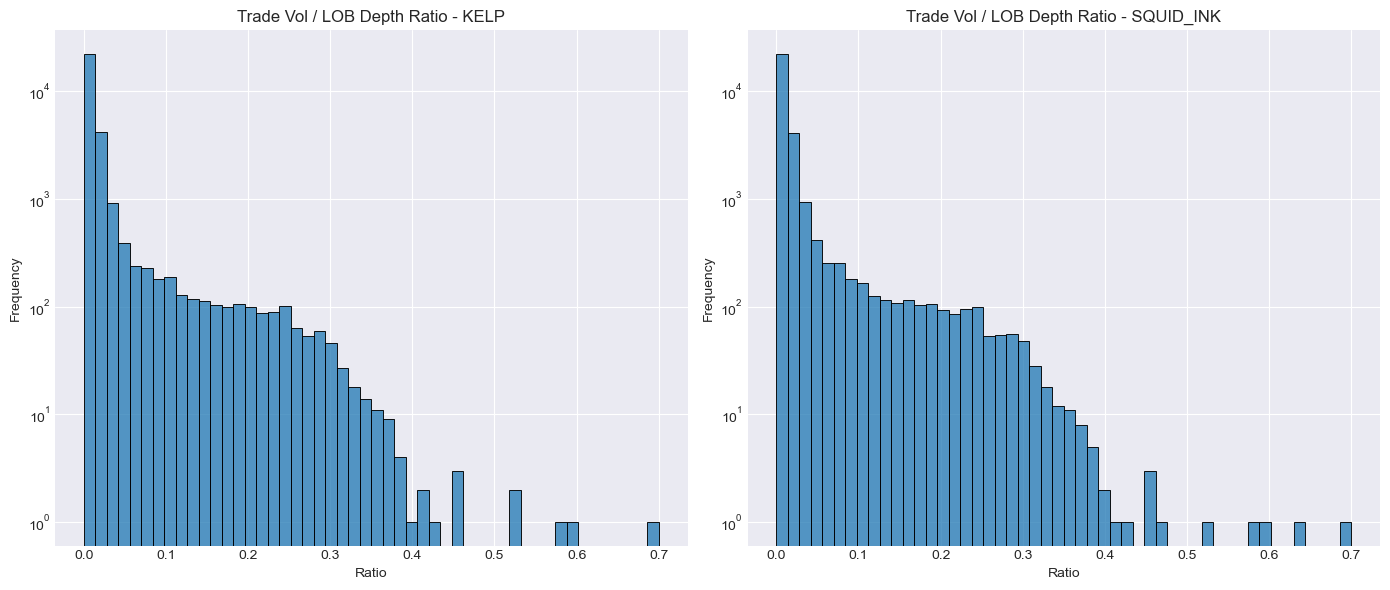


--- Analyses 2 (cont.) & 3 Finished ---


In [6]:
# --- Analysis 2 (Continued): Trade Characterization ---
# --- Analysis 3: Trade Volume vs LOB Volume Discrepancy ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


PRODUCTS_TO_ANALYZE = ['KELP', 'SQUID_INK']


try:
    trades_full_df
    merged_df_clean_lagged 
    pivoted_volumes_clean # Used to identify LOB columns
except NameError:
    print("Error: Ensure 'trades_full_df', 'merged_df_clean_lagged', and 'pivoted_volumes_clean' are defined from previous cells.")
    # You might need to re-run the cells that define these DataFrames.
    raise

print("--- Analysis 2 (Continued): Trade Characterization ---")

# 1. Basic Trade Size Statistics
print("\nCalculating trade size statistics...")
if not trades_full_df.empty:
    # Filter for the products we are analyzing
    trades_filtered = trades_full_df[trades_full_df['symbol'].isin(PRODUCTS_TO_ANALYZE)].copy()
    # Ensure quantity is positive for size analysis (trades are directional in source)
    trades_filtered['trade_size'] = trades_filtered['quantity'].abs()

    if not trades_filtered.empty:
        trade_size_stats = trades_filtered.groupby('symbol')['trade_size'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
        print("\nTrade Size Statistics per Product:")
        print(trade_size_stats)

        # 2. Trade Size Histograms
        print("\nPlotting trade size histograms...")
        plt.figure(figsize=(12, 5))
        for i, product in enumerate(PRODUCTS_TO_ANALYZE):
            plt.subplot(1, len(PRODUCTS_TO_ANALYZE), i + 1)
            product_trades = trades_filtered[trades_filtered['symbol'] == product]['trade_size']
            if not product_trades.empty:
                sns.histplot(product_trades, bins=50, kde=False)
                plt.title(f'Trade Size Distribution - {product}')
                plt.xlabel('Trade Size')
                plt.ylabel('Frequency')
            else:
                 plt.title(f'No Trades Found - {product}')
        plt.tight_layout()
        plt.show()
    else:
        print("No trades found for the specified PRODUCTS_TO_ANALYZE.")

else:
    print("Trade data ('trades_full_df') is empty. Skipping trade characterization.")


print("\n--- Analysis 3: Trade Volume vs LOB Volume Discrepancy ---")


analysis_df = merged_df_clean_lagged.copy()
discrepancy_stats = {}

# Calculate LOB depth and Trade/LOB ratio for each product
print("\nCalculating LOB depth and Trade-to-LOB ratios...")
for product in PRODUCTS_TO_ANALYZE:
    bid_col = f'total_bid_volume_{product}'
    ask_col = f'total_ask_volume_{product}'
    trade_vol_col = f'total_trade_volume_{product}'
    ratio_col = f'trade_to_lob_ratio_{product}'
    depth_col = f'total_lob_depth_{product}'

    if bid_col in analysis_df.columns and ask_col in analysis_df.columns and trade_vol_col in analysis_df.columns:
        # Calculate total LOB depth (sum of absolute bid and ask volumes)
        # Assuming ask volumes are positive as calculated in Analysis 1 (pivoted_volumes_clean)
        analysis_df[depth_col] = analysis_df[bid_col] + analysis_df[ask_col]

        # Calculate Trade Volume to LOB Depth Ratio
        # Avoid division by zero: replace ratio with 0 or NaN if depth is 0
        analysis_df[ratio_col] = np.where(
            analysis_df[depth_col] > 0,
            analysis_df[trade_vol_col] / analysis_df[depth_col],
            0 # Assign 0 if LOB depth is 0, could also use np.nan
        )

        print(f"\nStatistics for {ratio_col}:")
        stats = analysis_df[ratio_col].describe(percentiles=[.25, .5, .75, .9, .95, .99])
        print(stats)
        discrepancy_stats[product] = stats

        # Identify timestamps with potentially high discrepancy (e.g., ratio > 95th percentile)
        high_ratio_threshold = analysis_df[ratio_col].quantile(0.95)
        high_discrepancy_times = analysis_df[analysis_df[ratio_col] > high_ratio_threshold][['day', 'timestamp', depth_col, trade_vol_col, ratio_col]]
        print(f"\nTop 5 timestamps with highest '{ratio_col}' (above {high_ratio_threshold:.4f}):")
        print(high_discrepancy_times.nlargest(5, ratio_col))

    else:
        print(f"Warning: Required columns for {product} not found in merged data. Skipping discrepancy analysis for this product.")

# Plotting the Trade-to-LOB Ratios
print("\nPlotting Trade-to-LOB Ratios...")
plt.figure(figsize=(14, 6))
plot_count = 0
for i, product in enumerate(PRODUCTS_TO_ANALYZE):
    ratio_col = f'trade_to_lob_ratio_{product}'
    if ratio_col in analysis_df.columns:
        plot_count += 1
        plt.subplot(1, len(PRODUCTS_TO_ANALYZE), plot_count) # Adjust subplot grid if needed
        sns.histplot(analysis_df[ratio_col], bins=50, kde=False)
        # Filter out potential extreme outliers for better visualization if needed
        # plt.xlim(0, analysis_df[ratio_col].quantile(0.99)) # Example: limit x-axis
        plt.title(f'Trade Vol / LOB Depth Ratio - {product}')
        plt.xlabel('Ratio')
        plt.ylabel('Frequency')
        plt.yscale('log') # Use log scale often helpful for skewed distributions

if plot_count > 0:
    plt.tight_layout()
    plt.show()
else:
    print("No ratio columns were available for plotting.")

print("\n--- Analyses 2 (cont.) & 3 Finished ---")

ANALYSES 4

In [7]:
# --- Analysis 4: Examining Activity Around High Trade/LOB Ratio Events (Historical Data) ---

import pandas as pd
import json # For potentially formatting output later if needed

# --- Configuration ---
# Reuse the same timestamps identified from Analysis 3 run on historical data
timestamps_to_investigate = [
    {'day': 0, 'timestamp': 94700},
    {'day': -1, 'timestamp': 718700},
    {'day': -1, 'timestamp': 1595500}, # Squid Ink specific high ratio event
    
    {'day': -1, 'timestamp': 85100},
    {'day': -1, 'timestamp': 460400},
]
products_in_event = ['KELP', 'SQUID_INK'] 
time_window = [-1, 0, 1] # Look at T-1, T, and T+1 relative to the event time

# --- Pre-computation Checks ---
try:
    prices_full_df 
    trades_full_df 
    analysis_df 
except NameError:
    print("Error: Ensure 'prices_full_df', 'trades_full_df', and 'analysis_df' are loaded.")
    print("You may need to re-run the initial data loading and Analysis 3 cells.")
    raise

# --- Helper Function for Display (Historical Data Version) ---
def display_historical_market_state(prices_df, trades_df, day, timestamp, products):
    """Extracts and prints historical LOB and trades for a given state."""
    print(f"--- State: Day {day}, Timestamp {timestamp} ---")

    # LOB Snapshot from prices_df
    lob_state = prices_df[(prices_df['day'] == day) & (prices_df['timestamp'] == timestamp) & (prices_df['product'].isin(products))]
    print("  Order Book Snapshot (Levels 1-3):")
    if lob_state.empty:
        print("    (No LOB data found for this timestamp/products)")
    else:
        # Select and format relevant LOB columns for clarity
        lob_cols = ['product',
                    'bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1',
                    'bid_price_2', 'bid_volume_2', 'ask_price_2', 'ask_volume_2',
                    'bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3']
        # Ensure columns exist before trying to select them
        lob_cols_present = [col for col in lob_cols if col in lob_state.columns]
        print(lob_state[lob_cols_present].to_string(index=False)) # Use to_string for better console table format


    # Market Trades from trades_df
    # Trades occurred *during* the interval leading up to this timestamp
    market_trades = trades_df[(trades_df['day'] == day) & (trades_df['timestamp'] == timestamp) & (trades_df['symbol'].isin(products))]
    print("\n  Market Trades during interval ending at this timestamp:")
    if market_trades.empty:
        print("    (No trades found for this timestamp/products)")
    else:
        trade_cols = ['symbol', 'price', 'quantity']
        # Ensure columns exist
        trade_cols_present = [col for col in trade_cols if col in market_trades.columns]
        print(market_trades[trade_cols_present].to_string(index=False))


# --- Main Loop ---
print("\n--- Analyzing High Discrepancy Event Windows (Historical Data) ---")

for event in timestamps_to_investigate:
    event_day = event['day']
    event_ts = event['timestamp']
    print(f"\n======================================================")
    print(f"Investigating Event: Day {event_day}, Timestamp {event_ts}")
    print(f"======================================================")

    # Add ratio context from Analysis 3 if available
    if 'analysis_df' in globals() and not analysis_df.empty:
         event_context = analysis_df[(analysis_df['day'] == event_day) & (analysis_df['timestamp'] == event_ts)]
         if not event_context.empty:
             for p in products_in_event:
                 ratio_col = f'trade_to_lob_ratio_{p}'
                 depth_col = f'total_lob_depth_{p}' # Calculated in analysis 3
                 trade_vol_col = f'total_trade_volume_{p}' # Calculated in analysis 3
                 if ratio_col in event_context.columns:
                     ratio = event_context.iloc[0][ratio_col]
                     depth = event_context.iloc[0].get(depth_col, 'N/A')
                     vol = event_context.iloc[0].get(trade_vol_col, 'N/A')
                     print(f"  Context ({p}): Ratio={ratio:.4f}, Depth={depth}, TradeVol={vol}")


    # Display states for T-1, T, T+1 using historical data
    for offset in time_window:
        current_ts = event_ts + (offset * 100) 

        # Handle day boundaries
        current_day = event_day
        if current_ts < 0 and event_day > -2:
            current_day -= 1
            current_ts += 1_000_000
        elif current_ts >= 1_000_000 and event_day < 0:
            current_day += 1
            current_ts -= 1_000_000

        # Check if data exists for this calculated day/timestamp before displaying
        price_exists = not prices_full_df[(prices_full_df['day'] == current_day) & (prices_full_df['timestamp'] == current_ts)].empty
        # Note: Trades might be empty even if price exists, which is normal

        if price_exists:
             display_historical_market_state(prices_full_df, trades_full_df, current_day, current_ts, products_in_event)
        else:
             print(f"\n--- State: Day {current_day}, Timestamp {current_ts} ---")
             print(f"  (No price data found for this historical state)")


print("\n--- Analysis 4 (Historical Data) Finished ---")


--- Analyzing High Discrepancy Event Windows (Historical Data) ---

Investigating Event: Day 0, Timestamp 94700
  Context (KELP): Ratio=0.6000, Depth=40.0, TradeVol=24.0
  Context (SQUID_INK): Ratio=0.6000, Depth=40.0, TradeVol=24.0
--- State: Day 0, Timestamp 94600 ---
  Order Book Snapshot (Levels 1-3):
  product  bid_price_1  bid_volume_1  ask_price_1  ask_volume_1  bid_price_2  bid_volume_2  ask_price_2  ask_volume_2  bid_price_3  bid_volume_3  ask_price_3  ask_volume_3
SQUID_INK         1967            25         1970            25          NaN           0.0          NaN           0.0          NaN           0.0          NaN           0.0
     KELP         2027            25         2030            25          NaN           0.0          NaN           0.0          NaN           0.0          NaN           0.0

  Market Trades during interval ending at this timestamp:
    (No trades found for this timestamp/products)
--- State: Day 0, Timestamp 94700 ---
  Order Book Snapshot (Levels

ANALYSES 5


--- Preparing Data ---
Data merged. Shape after merge and dropping rows with missing BBO: (17672, 11)

--- Inferring Trade Direction (Level Matching) ---
Inferred Trade Direction Counts (Level Matching):
product    inferred_direction
KELP       buy                   2915
           sell                  5586
           unknown                333
SQUID_INK  buy                   2954
           sell                  5553
           unknown                331
Name: abs_quantity, dtype: int64

Inferred Trade Direction Volume (Level Matching):
product    inferred_direction
KELP       buy                   10393
           sell                  14297
           unknown                 450
SQUID_INK  buy                   10555
           sell                  14229
           unknown                 424
Name: abs_quantity, dtype: int64

Note: 664 trades couldn't be matched to available bid/ask levels 1-3 and were marked 'unknown'.

--- Analyzing Directional Volume ---
Aggregating 'unknown'

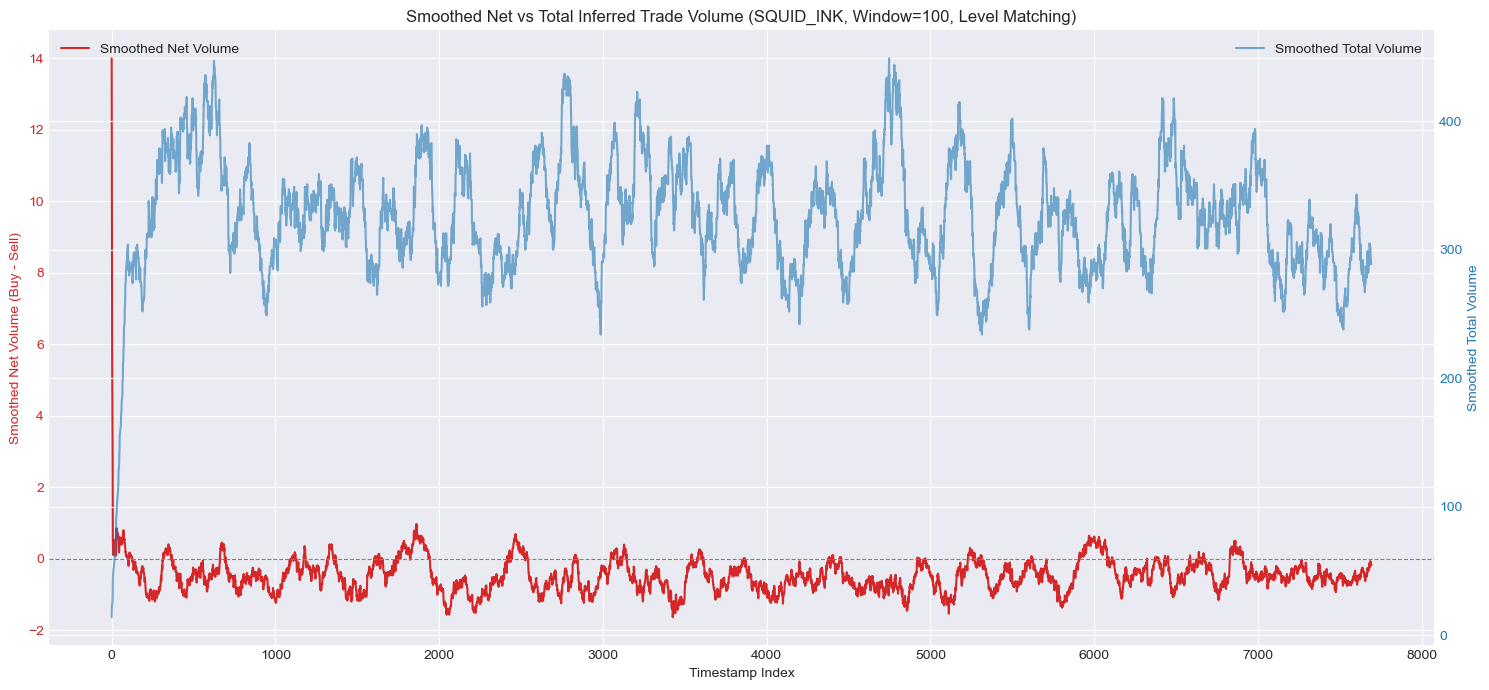


--- Analyzing Trade Sizes by Inferred Direction (Level Matching) ---


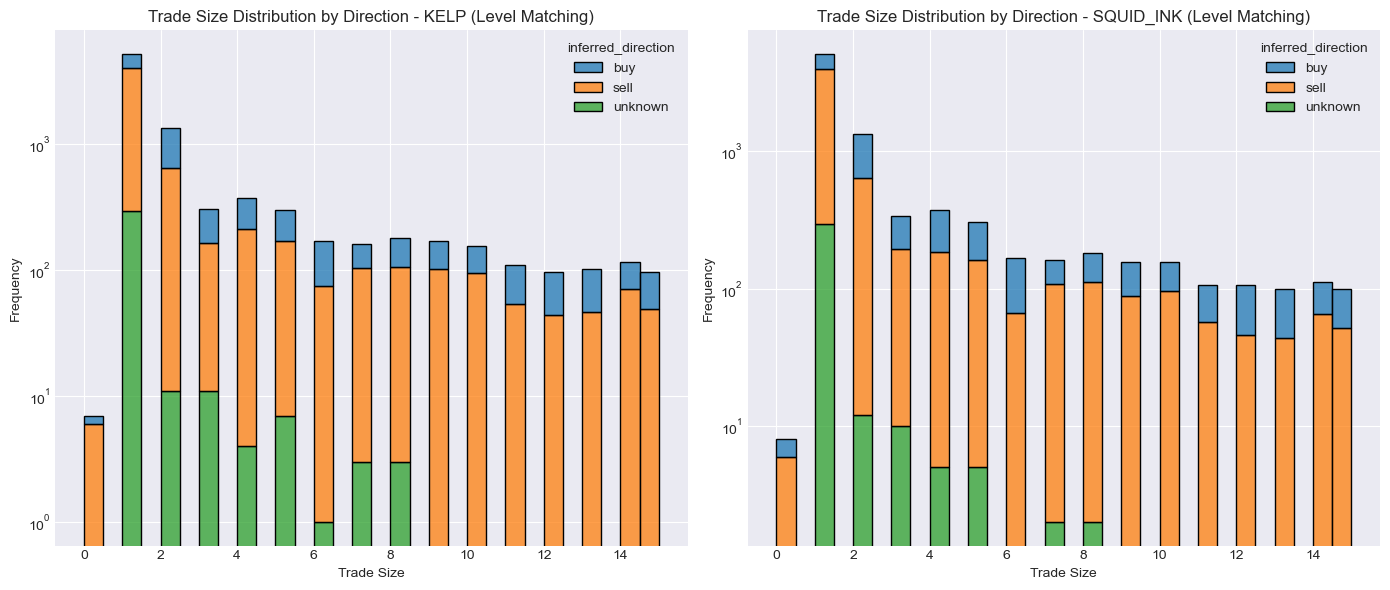


--- Analysis 5 (Level Matching) Finished ---


In [8]:
# --- Analysis 5: Characterizing Historical Market Trades (Level Matching) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PRODUCTS_TO_ANALYZE = ['KELP', 'SQUID_INK']

try:
    trades_full_df
    prices_full_df
except NameError:
    print("Error: Ensure 'trades_full_df' and 'prices_full_df' are loaded from historical CSVs.")
    raise

print("\n--- Preparing Data ---")

# Select necessary price columns, including up to level 3
price_cols = [
    'day', 'timestamp', 'product',
    'bid_price_1', 'bid_price_2', 'bid_price_3',
    'ask_price_1', 'ask_price_2', 'ask_price_3'
]
# Check which price columns are actually available in the DataFrame
available_price_cols = [col for col in price_cols if col in prices_full_df.columns]
missing_price_cols = set(price_cols) - set(available_price_cols)
if missing_price_cols:
    print(f"Warning: Missing expected price columns: {missing_price_cols}")

prices_subset = prices_full_df[available_price_cols].copy()
trades_subset = trades_full_df[['day', 'timestamp', 'symbol', 'price', 'quantity']].copy()
trades_subset.rename(columns={'symbol': 'product'}, inplace=True)

# Merge trades with prices at the same timestamp
merged_trades_prices = pd.merge(
    trades_subset,
    prices_subset,
    on=['day', 'timestamp', 'product'],
    how='left'
)

# Drop rows where essential price info (e.g., BBO) might be missing after merge
# We need at least bid_price_1 and ask_price_1 for a basic comparison
merged_trades_prices.dropna(subset=['bid_price_1', 'ask_price_1'], inplace=True)
print(f"Data merged. Shape after merge and dropping rows with missing BBO: {merged_trades_prices.shape}")


print("\n--- Inferring Trade Direction (Level Matching) ---")

# Define conditions for matching trade price against known ask/bid levels
# Handle potential NaNs in level 2/3 prices using fillna with a value that won't match trade prices
ask_levels = [col for col in ['ask_price_1', 'ask_price_2', 'ask_price_3'] if col in merged_trades_prices.columns]
bid_levels = [col for col in ['bid_price_1', 'bid_price_2', 'bid_price_3'] if col in merged_trades_prices.columns]

# Create boolean series for matching asks or bids
matches_ask = pd.Series(False, index=merged_trades_prices.index)
for col in ask_levels:
     # Ensure comparison is valid even if price level is NaN
    matches_ask |= (merged_trades_prices['price'] == merged_trades_prices[col]) & merged_trades_prices[col].notna()

matches_bid = pd.Series(False, index=merged_trades_prices.index)
for col in bid_levels:
    matches_bid |= (merged_trades_prices['price'] == merged_trades_prices[col]) & merged_trades_prices[col].notna()

# Apply conditions using np.select
conditions = [
    matches_ask,  # Trade price matched an ask level
    matches_bid   # Trade price matched a bid level
]
choices = ['buy', 'sell']
merged_trades_prices['inferred_direction'] = np.select(conditions, choices, default='unknown') # Default if no match

merged_trades_prices['abs_quantity'] = merged_trades_prices['quantity'].abs()

print("Inferred Trade Direction Counts (Level Matching):")
print(merged_trades_prices.groupby(['product', 'inferred_direction'])['abs_quantity'].count())
print("\nInferred Trade Direction Volume (Level Matching):")
print(merged_trades_prices.groupby(['product', 'inferred_direction'])['abs_quantity'].sum())
unknown_count = (merged_trades_prices['inferred_direction'] == 'unknown').sum()
if unknown_count > 0:
    print(f"\nNote: {unknown_count} trades couldn't be matched to available bid/ask levels 1-3 and were marked 'unknown'.")


print("\n--- Analyzing Directional Volume ---")

directional_volume = merged_trades_prices.groupby(['day', 'timestamp', 'product', 'inferred_direction'])['abs_quantity'].sum().unstack(fill_value=0)

# Ensure buy/sell columns exist after unstacking
if 'buy' not in directional_volume.columns: directional_volume['buy'] = 0
if 'sell' not in directional_volume.columns: directional_volume['sell'] = 0
if 'unknown' in directional_volume.columns:
     print("Aggregating 'unknown' volume direction for total volume calculation.")
     total_vol_cols = ['buy', 'sell', 'unknown']
else:
     total_vol_cols = ['buy', 'sell']


directional_volume.reset_index(inplace=True)
directional_volume['net_volume'] = directional_volume['buy'] - directional_volume['sell']
# Include 'unknown' in total volume if present
directional_volume['total_volume'] = directional_volume[total_vol_cols].sum(axis=1)


product_to_plot = 'SQUID_INK' # Change as needed
print(f"\nPlotting Buy vs Sell Volume for {product_to_plot}...")
subset_plot = directional_volume[directional_volume['product'] == product_to_plot].copy()

if not subset_plot.empty:
    subset_plot.sort_values(by=['day', 'timestamp'], inplace=True)
    window_size = 100
    subset_plot['net_volume_smooth'] = subset_plot['net_volume'].rolling(window=window_size, min_periods=1).mean()
    subset_plot['total_volume_smooth'] = subset_plot['total_volume'].rolling(window=window_size, min_periods=1).sum()

    fig, ax1 = plt.subplots(figsize=(15, 7))
    color = 'tab:red'
    ax1.set_xlabel('Timestamp Index')
    ax1.set_ylabel('Smoothed Net Volume (Buy - Sell)', color=color)
    subset_plot['numeric_idx'] = subset_plot.reset_index().index
    ax1.plot(subset_plot['numeric_idx'], subset_plot['net_volume_smooth'], color=color, label='Smoothed Net Volume')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Smoothed Total Volume', color=color)
    ax2.plot(subset_plot['numeric_idx'], subset_plot['total_volume_smooth'], color=color, alpha=0.6, label='Smoothed Total Volume')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title(f'Smoothed Net vs Total Inferred Trade Volume ({product_to_plot}, Window={window_size}, Level Matching)')
    fig.tight_layout()
    plt.show()
else:
    print(f"No data to plot for {product_to_plot}")


print("\n--- Analyzing Trade Sizes by Inferred Direction (Level Matching) ---")

plt.figure(figsize=(14, 6))
plot_count = 0
hue_order = ['buy', 'sell', 'unknown'] if unknown_count > 0 else ['buy', 'sell']

for i, product in enumerate(PRODUCTS_TO_ANALYZE):
    plot_count += 1
    plt.subplot(1, len(PRODUCTS_TO_ANALYZE), plot_count)
    product_data = merged_trades_prices[merged_trades_prices['product'] == product]
    if not product_data.empty:
        sns.histplot(data=product_data, x='abs_quantity', hue='inferred_direction',
                     multiple='stack', bins=30, kde=False,
                     hue_order=hue_order) # Use dynamic hue order
        plt.title(f'Trade Size Distribution by Direction - {product} (Level Matching)')
        plt.xlabel('Trade Size')
        plt.ylabel('Frequency')
        plt.yscale('log')
    else:
         plt.title(f'No Trades Found - {product}')

if plot_count > 0:
    plt.tight_layout()
    plt.show()
else:
    print("No data available for directional trade size plotting.")


print("\n--- Analysis 5 (Level Matching) Finished ---")

Alpha Implications: The core conclusions for alpha generation remain largely the same as before. The sell-side pressure and small trade size dominance are the main takeaways. The 'unknown' trades themselves are likely too infrequent and ambiguous to be a direct signal, but they reinforce the idea that large trades hitting deeper levels might occur, potentially having more impact than trades just interacting with the BBO.


SEPERATING BOT BEHAVIOUR

In [9]:
# --- Goal 2: Visualizing Inferred Taker Bot Behavior (Interactive Plotly with Size Filter) ---

import pandas as pd
import numpy as np
# Ensure Plotly is installed: pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


min_trade_size_to_display = 1



try:
    merged_trades_prices
except NameError:
    print("Error: Ensure 'merged_trades_prices' DataFrame from Analysis 5 (Level Matching) is available.")
    raise

PRODUCTS_TO_PLOT = ['KELP', 'SQUID_INK']
print(f"\n--- Creating Interactive Plots (Min Trade Size >= {min_trade_size_to_display}) ---")

# Number of days in the data
days = sorted(merged_trades_prices['day'].unique())
n_days = len(days)

# Create subplots
subplot_titles = [f"{prod} - Day {day}" for prod in PRODUCTS_TO_PLOT for day in days]
fig = make_subplots(rows=n_days * len(PRODUCTS_TO_PLOT), cols=1, subplot_titles=subplot_titles)

current_row = 1

for product in PRODUCTS_TO_PLOT:
    print(f"Processing {product}...")
    required_cols = ['day', 'timestamp', 'product', 'price', 'abs_quantity', 'inferred_direction', 'bid_price_1', 'ask_price_1']
    if not all(col in merged_trades_prices.columns for col in required_cols):
         print(f"  Error: Missing required columns in merged_trades_prices for {product}. Skipping.")
         current_row += n_days
         continue

    product_data = merged_trades_prices[
        (merged_trades_prices['product'] == product) &
        (merged_trades_prices['bid_price_1'].notna()) &
        (merged_trades_prices['ask_price_1'].notna())
    ].copy()

    if product_data.empty:
        print(f"  No data found for {product} after filtering. Skipping plots.")
        current_row += n_days
        continue

    # Calculate mid_price
    product_data['mid_price'] = (product_data['bid_price_1'] + product_data['ask_price_1']) / 2

    # Separate buys and sells
    buy_trades = product_data[product_data['inferred_direction'] == 'buy']
    sell_trades = product_data[product_data['inferred_direction'] == 'sell']

    # Get mid-price series
    mid_price_series = product_data.groupby(['day', 'timestamp'])['mid_price'].first().reset_index()

    for day in days:
        print(f"  Plotting Day {day} for {product}...")
        ax_row = current_row #

        #
        buy_trades_day = buy_trades[buy_trades['day'] == day].copy() #
        sell_trades_day = sell_trades[sell_trades['day'] == day].copy()
        mid_price_day = mid_price_series[mid_price_series['day'] == day]

       
        buy_trades_day = buy_trades_day[buy_trades_day['abs_quantity'] >= min_trade_size_to_display]
        sell_trades_day = sell_trades_day[sell_trades_day['abs_quantity'] >= min_trade_size_to_display]
        # --- ***************************** ---


        # Add Mid-Price Line trace
        if not mid_price_day.empty:
            fig.add_trace(go.Scatter(
                x=mid_price_day['timestamp'], y=mid_price_day['mid_price'], mode='lines',
                name='Mid-Price', line=dict(color='black', width=1),
                legendgroup='mid', showlegend=(current_row == 1) # Show legend only on first subplot
            ), row=ax_row, col=1)

        # Add Buy Trades scatter trace (if any remain after filtering)
        if not buy_trades_day.empty:
            fig.add_trace(go.Scatter(
                x=buy_trades_day['timestamp'], y=buy_trades_day['price'], mode='markers',
                name='Inferred Buy (Hit Ask)',
                marker=dict(color='green', symbol='triangle-up', size=5 + np.log1p(buy_trades_day['abs_quantity']) * 2, opacity=0.7, line=dict(width=0.5, color='DarkSlateGrey')),
                customdata=buy_trades_day[['abs_quantity']],
                hovertemplate='<b>Buy</b><br>Price: %{y}<br>Timestamp: %{x}<br>Qty: %{customdata[0]}<extra></extra>',
                legendgroup='buy', showlegend=(current_row == 1)
            ), row=ax_row, col=1)

        # Add Sell Trades scatter trace (if any remain after filtering)
        if not sell_trades_day.empty:
            fig.add_trace(go.Scatter(
                x=sell_trades_day['timestamp'], y=sell_trades_day['price'], mode='markers',
                name='Inferred Sell (Hit Bid)',
                marker=dict(color='red', symbol='triangle-down', size=5 + np.log1p(sell_trades_day['abs_quantity']) * 2, opacity=0.7, line=dict(width=0.5, color='DarkSlateGrey')),
                customdata=sell_trades_day[['abs_quantity']],
                hovertemplate='<b>Sell</b><br>Price: %{y}<br>Timestamp: %{x}<br>Qty: %{customdata[0]}<extra></extra>',
                legendgroup='sell', showlegend=(current_row == 1)
            ), row=ax_row, col=1)

        # Increment row index for the next subplot
        current_row += 1

# Update layout
fig.update_layout(
    height=300 * n_days * len(PRODUCTS_TO_PLOT),
    title_text=f"Inferred Taker Activity vs. Mid-Price (Interactive, Min Trade Size >= {min_trade_size_to_display})", # Update title
    hovermode='closest'
)
# Update axes titles
for i in range(1, current_row):
     try: # Use try-except in case a row was skipped entirely
        fig.update_yaxes(title_text="Price", row=i, col=1)
     except ValueError: pass
for i, product in enumerate(PRODUCTS_TO_PLOT):
     last_row_for_product = (i + 1) * n_days
     if last_row_for_product < current_row:
        try:
            fig.update_xaxes(title_text="Timestamp", row=last_row_for_product, col=1)
        except ValueError: pass


fig.show()

print("\n--- Goal 2 Interactive Visualization with Size Filter Finished ---")


--- Creating Interactive Plots (Min Trade Size >= 1) ---
Processing KELP...
  Plotting Day -1 for KELP...
  Plotting Day 0 for KELP...
  Plotting Day 1 for KELP...
Processing SQUID_INK...
  Plotting Day -1 for SQUID_INK...
  Plotting Day 0 for SQUID_INK...
  Plotting Day 1 for SQUID_INK...



--- Goal 2 Interactive Visualization with Size Filter Finished ---
